In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

In [2]:
test = pd.read_csv('./merchants_test.csv', sep=';')
train = pd.read_csv('./merchants_train.csv', sep=';')
transactions = pd.read_csv('./transactions.csv',  sep=',')

In [3]:
df = pd.merge(transactions, train, on='merchant_id', how='left', suffixes=('_transactions', '_train'))

In [4]:
df.head()

,merchant_id,latitude_transactions,longitude_transactions,real_transaction_dttm,record_date,latitude_train,longitude_train
0,178,0.000000,0.000000,9:34:47,9:30:36,55.055553,82.911833
1,178,55.055995,82.912991,17:49:50,17:54:24,55.055553,82.911833
2,178,0.000000,0.000000,9:34:47,9:31:22,55.055553,82.911833
3,178,55.056034,82.912734,17:49:50,17:43:01,55.055553,82.911833
4,178,55.056034,82.912734,17:49:50,17:45:17,55.055553,82.911833


Посмотрим распредленеие мерчантов на карте

In [5]:
from mpl_toolkits.basemap import Basemap

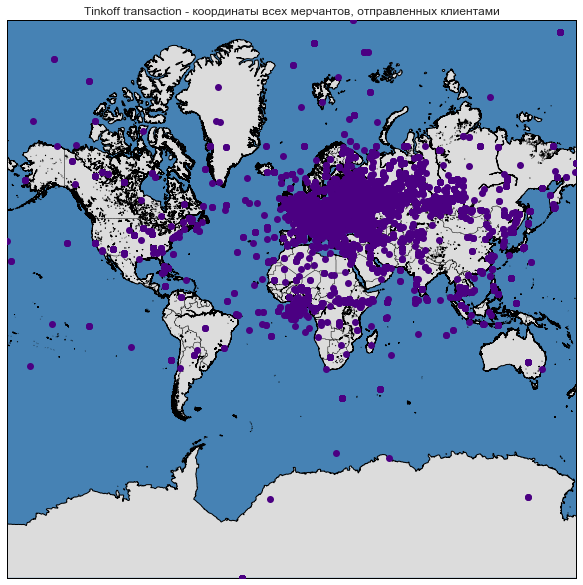

In [6]:
plt.figure(1, figsize=(20,10))
m = Basemap(projection='merc',
             llcrnrlat=df.latitude_transactions.min(),
             urcrnrlat=df.latitude_transactions.max(),
             llcrnrlon=df.longitude_transactions.min(),
             urcrnrlon=df.longitude_transactions.max(),
             lat_ts=0,
             resolution='h')

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'gainsboro')
m.drawmapboundary(fill_color='steelblue')
x, y = m(df.longitude_transactions.tolist(), df.latitude_transactions.tolist())
m.plot(x, y, 
            'o',                    # marker shape
            c="indigo", lw=0, alpha=1, zorder=5         # marker size
            )
plt.title("Tinkoff transaction - координаты всех мерчантов, отправленных клиентами")
plt.show()

Уберём выбросы на основе данных о реальных координатах мерчантов (содержаться в traine)

In [7]:
df = df[-(df.latitude_transactions>df.latitude_train.max())]
df = df[-(df.latitude_transactions<df.latitude_train.min())]
df = df[-(df.longitude_transactions<df.longitude_train.min())]
df = df[-(df.longitude_transactions>df.longitude_train.max())]

Посмотрим, как соотносятся оправленные сотрудниками координаты мерчантов и реальные координаты этих мерчантов

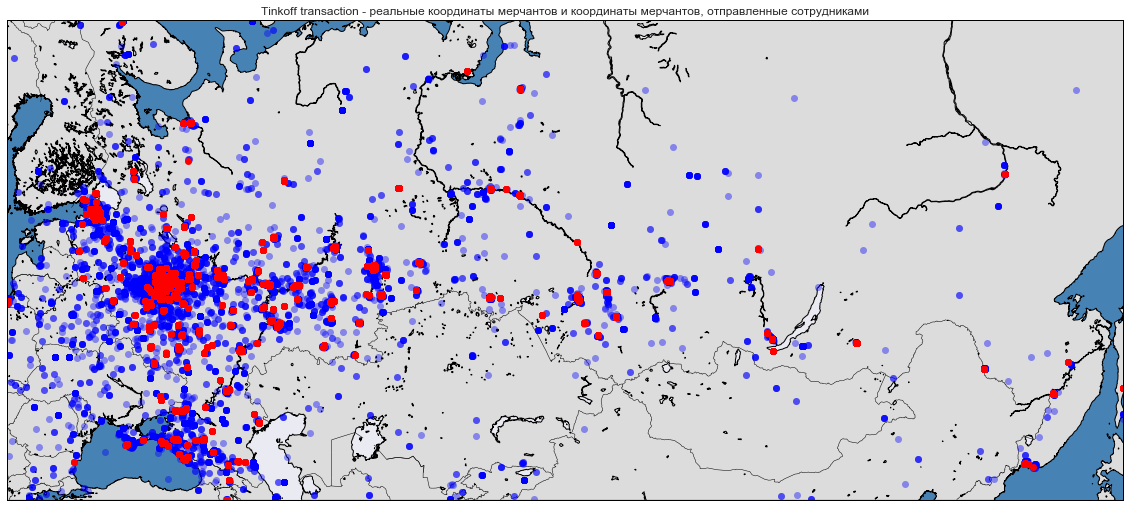

In [8]:
plt.figure(1, figsize=(20,10))
m = Basemap(projection='merc',
             llcrnrlat=df.latitude_transactions.min(),
             urcrnrlat=df.latitude_transactions.max(),
             llcrnrlon=df.longitude_transactions.min(),
             urcrnrlon=df.longitude_transactions.max(),
             lat_ts=0,
             resolution='h')

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'gainsboro')
m.drawmapboundary(fill_color='steelblue')
x, y = m(df.longitude_transactions.tolist(), df.latitude_transactions.tolist())
x1, y1 = m(df.longitude_train.tolist(), df.latitude_train.tolist())

m.plot(x, y, 
            'o',                    # marker shape
            c="blue", lw=0, alpha=0.4,         # marker size
            )

m.plot(x1, y1, 
            'o',                    # marker shape
            c="red", lw=0, alpha=1,        # marker size
            )
plt.title("Tinkoff transaction - реальные координаты мерчантов и координаты мерчантов, отправленные сотрудниками")
plt.show()

На данной карте мы видим, что реальные координаты и координаты, отправленные сотрудниками, очень сильно расходятся. Самая простая идея для восстановления геопозиции мерчанта - это взять медиану от всех координат, отправленных для каждого конкретного мерчанта. Собственно, сначала посмотрим, как распределены среднее и медиана для координат мерчантов, которые нам нужно предсказать:

In [9]:
df[df.merchant_id.isin(test.merchant_id)].groupby('merchant_id')[['latitude_transactions','longitude_transactions']].agg([np.mean, np.std, np.median])

latitude_transactions                      longitude_transactions  \
                             mean       std     median                   mean   
merchant_id                                                                     
361                     56.132504  1.215519  55.750347              51.600004   
428                     55.622143  0.079549  55.621785              37.646961   
490                     58.863910  2.090437  59.900721              32.150948   
1175                    55.222014  2.499648  55.738291              37.900483   
1239                    55.779990  0.033850  55.775341              37.567195   
1476                    59.516532  1.273017  59.907086              31.122539   
1601                    58.774140  2.286775  59.941775              30.798035   
1628                    51.649128  7.103520  55.750347              38.399222   
1676                    49.217367  5.095535  46.337105              43.727202   
1916                    56.216851  0.509343  56.304558              42.899218   
2189                    56.771628  0.012858  56.766253              60.696189   
2726                    55.753036  0.006014  55.750347              37.610518   
3077                    55.803070  0.045480  55.807710              37.464079   
4698                    59.982848  0.035760  59.994266              30.269967   
5315                    56.312804  0.589692  56.832358              49.982553   
5392                    55.920731  0.156363  55.946273              37.412110   
6019                    55.711499  0.032767  55.709350              37.574945   
6261                    55.606713  0.291841  55.726089              37.852306   
7536                    59.021434  0.790347  59.094059              37.191114   
8088                    59.242787  1.710941  59.942243              31.556196   
8233                    55.758685  0.050111  55.750347              37.548642   
8783                    55.702507  0.086188  55.656477              37.798563   
8787                    59.945403  0.009391  59.940404              30.404410   
8969                    55.737993  0.076846  55.777170              37.607701   
9239                    56.915404  2.601663  55.778319              36.365662   
10773                   59.999027  0.000000  59.999027              30.314634   
11995                   56.066204  1.990201  55.761105              37.808565   
12251                   55.784609  0.088949  55.750347              37.925550   
12455                   55.731106  0.131248  55.743353              37.543223   
12903                   55.709999  0.082144  55.750347              39.917108   
...                           ...       ...        ...                    ...   
1272614                 47.490792  4.248757  45.142267              41.385794   
1273227                 55.679096  0.056215  55.657682              37.821241   
1276615                 58.172789  2.336309  59.922309              33.345321   
1289860                 55.759607  0.004730  55.761565              37.640860   
1290452                 55.749498  0.002300  55.749245              37.539605   
1292654                 55.748642  0.000659  55.748937              37.588258   
1302284                 56.815787  0.001671  56.816725              35.895336   
1305189                 55.861341  0.005696  55.863645              37.600762   
1305602                 59.930789  0.010736  59.924269              30.333527   
1311331                 55.733262  0.025087  55.733270              37.619865   
1327442                 55.731078  0.041162  55.746750              37.528299   
1328720                 56.009792  0.000000  56.009792              37.198262   
1338248                 55.759837  0.010036  55.759174              37.621325   
1340687                 55.457067  1.913545  55.751955              37.707639   
1349074                 55.898814  0.038455  55.914809              37.592933   
1354334                 58.790349  2.076778

В качестве ответа берем медиану:

In [10]:
group = df[df.merchant_id.isin(test.merchant_id)].groupby('merchant_id')[['latitude_transactions','longitude_transactions']].agg(np.median)

In [11]:
group

,latitude_transactions,longitude_transactions
merchant_id,,
361,55.750347,37.623851
428,55.621785,37.664236
490,59.900721,30.338137
1175,55.738291,37.602035
1239,55.775341,37.583508
1476,59.907086,30.483129
1601,59.941775,30.273232
1628,55.750347,37.623511
1676,46.337105,45.527249


In [12]:
result = test.join(group, on='merchant_id').drop(['latitude','longitude'], axis=1).fillna(0)

In [143]:
result.to_csv('predict_coord.csv', index=False)